## Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading in the DataFrame as *data*

### Handling Money and Sales, so money formatting is more appropriate for certain values
For this, I created a formatting method for currency.

In [2]:
data = pd.read_csv('datasets/shopify_data.csv')

In [7]:
def money_format(x):
    return "$"+('%.2f' % x).rstrip('0').rstrip('.')

## Getting some information about the dataframe

In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB
None


***
I want to first verify that that there the entire dataframe is filled and NA/NaN values are not present.

For this, I use the *.info()* method on my dataframe

This is also showing me that there are 5000 rows and 7 columns with int and object types

***

***
# How did the wrong Average Order Value (AOV) value come into play?

### The value of \$3145.13 was taken from the average of the 'order_amount' column
This is visisble in the *mean* row and *order_amount* column

In [9]:
data.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


In [10]:
print("Incorrect AOV:",money_format(data['order_amount'].mean()))

Incorrect AOV: $3145.13


***
## Moving Forward to get a more appropriate AOV...
First, lets confirm that there are indeed 100 different shops.

In [11]:
list_of_shops = data['shop_id'].unique()

## Now, I will find the total number of items bought for the total amount of money paid. 
To do this, I will break each order into items and populate a list

In [12]:
list_items = []
def AOV_find(data):
    list_of_shops = data['shop_id'].unique()
    list_of_items = []

    for shop_id_num in list_of_shops:    
        #print(data[data["shop_id"] == shop_id_num][['order_amount','total_items']].sum())

        total_item_count = data[data["shop_id"] == shop_id_num]['total_items'].sum()
        average_cost = data[data["shop_id"] == shop_id_num]['order_amount'].sum()/total_item_count
        #print(average_cost)
        for x in range(total_item_count):
            list_of_items.append(average_cost)
    print("Median cost per item:",money_format(np.median(np.array(list_of_items))))
    print("Average cost per item based on total cost of all items:",money_format(np.mean(np.array(list_of_items))))
    return list_of_items

In [13]:
list_items = AOV_find(data)

Median cost per item: $352
Average cost per item based on total cost of all items: $357.92


# Plotting my data to see how it looks

## Histogram below will show average cost per item, regardless of how many sneakers were purchased in a transaction

In [20]:
def hist_num_items():
    counts, edges, plot = plt.hist(np.array(list_items), bins = 10)
    plt.xlabel('cost per item / $')
    plt.ylabel('Number of items sold')
    plt.show()
    #print(edges1)
    print("Number of items sold in each bin that belongs to the above histogram:\n",counts)
    plt.close()
    return counts, edges

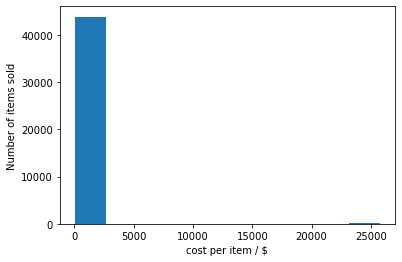

Number of items sold in each bin that belongs to the above histogram:
 [43848.     0.     0.     0.     0.     0.     0.     0.     0.    88.]


In [21]:
counts1,edges1 = hist_num_items()

There is clearly something skewing this data, so I should look out for why we have such extremes in pricing.

In [22]:
data['average_cost_per_item'] = data['order_amount']/data['total_items']


def hist_average_cost(data):


    #Finding values greater than the average due to average cost being greater than the median cost

    data.sort_values(by = 'average_cost_per_item')
    counts, edges, plot = plt.hist(data['average_cost_per_item'], bins = 10)
    plt.xlabel('Average price per item by shop / $')
    plt.ylabel('Number of shops')
    plt.show()
    #print(edges2)
    #print((edges2[8]-edges2[7])/2)
    print("Number of shops that belong to each average price bin that belongs to the above histogram:\n",counts)
    plt.close()
    return counts,edges

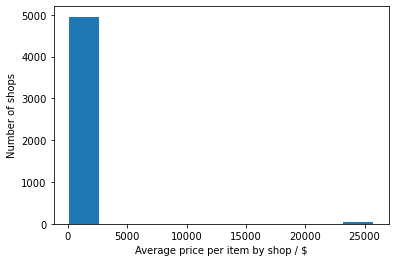

Number of shops that belong to each average price bin that belongs to the above histogram:
 [4954.    0.    0.    0.    0.    0.    0.    0.    0.   46.]


In [23]:
counts2, edges2 = hist_average_cost(data)

## Comparing the size of bins and count of each bin shows that the each transaction does not equate to a single item purchased
Bin edges align and confirm that all data is accounted for.

Count of each bin lines up for the middle, but not the extremes.

### This gives me some confirmation that I can possibly omit these higher prices. This is possibly caused by a currency difference or a very high spike in demand, which is unlikely
Further investigation into the latter is pending, but perhaps can be confirmed via a line plot based on time of transactions

In [24]:
print(edges1 == edges2)

[ True  True  True  True  True  True  True  True  True  True  True]


In [25]:
print(counts1 == counts2)

[False  True  True  True  True  True  True  True  True False]


### THIS IS SHOWING THAT THERE IS A STORE OR A FEW STORES THAT ARE CHARGING A VERY HIGH PRICE FOR SNEAKERS ON AVERAGE
### 88 PAIRS OF SNEAKERS SOLD IN 46 TRANSACTIONS at the extreme of pricing (>$20000/pair), but 

***
This made me want to know what other "abnormalities" or unique values per column that may exist.
First, I looked at the x-axis parameters from the above histograms.


In [26]:
print("Total Items:",data['total_items'].unique())
print("Unique Average Cost per Item:",data['average_cost_per_item'].unique())

Total Items: [   2    1    4    3    5    6 2000    8]
Unique Average Cost per Item: [  158.    94.   148.   128.   142.   187.   112.   132.   118.   184.
   201.   160.   116.   153.   156.   176.   163.   127.   146.   140.
   130.   169.   164.   129.   101.   173.   122.   190.   134.   161.
   352.   181.   144.   166.   145.   117.   193.   133.   171.   147.
   138.   178.   177.   136.   154.   131.   165.   155. 25725.   172.
   149.   196.    90.   114.   168.   162.   195.   111.]


## Looking at the the first list, "Total Items", which is the unique number of items purchased per order, one value stands out: 2000 sneakers purchased per order

## The next list, "Unique Average Cost per Item," shows that there are sneakers being purchased for \\$25725 per pair. This is the anomalous finding as depicted from this histogram
***
Then I moved towards understanding the other columns.


In [27]:
print(data.nunique())

order_id                 5000
shop_id                   100
user_id                   301
order_amount              258
total_items                 8
payment_method              3
created_at               4702
average_cost_per_item      58
dtype: int64


### The details above show that there are 5000 unique orders and 100 unique shop ids, which we knew. These 100 shops sold these sneakers are 58 different prices, accepted 3 different payment methods, and sold 8 different quantities of sneakers per order. The latter quantity and the average price per item have already been found (shown 2 blocks of code above)

### Fixing the 'created_at' column to be of datetime format

In [28]:
data['transaction_time'] = pd.to_datetime(data['created_at']).dt.strftime('%m/%d/%Y %H:%M')

### Adding a month column for better datetime management in plots

In [29]:
data['month'] = pd.to_datetime(data['created_at']).dt.strftime('%m/%Y')

***

In [30]:
def line_average_cost_per_pair():
    data.plot(kind = "line", x = 'month', y = 'average_cost_per_item', title = 'Average Cost per Pair of Sneakers based on Time of Transaction')
    plt.xticks(rotation = '45')
    plt.show()
    plt.close()

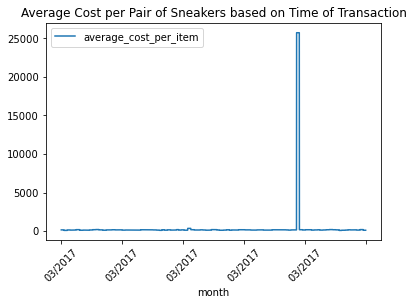

In [31]:
line_average_cost_per_pair()

## It appears that around March 2017, the price for sneakers spiked to approximately $25725, but then immediately went back down. This is an indicator that either a merchant error occurred or the currency type is wrong.
I am removing data associated with this from further consideration and recompute the average and median

In [32]:
original_data = data
print(data['average_cost_per_item'].max())
data = data[data['average_cost_per_item'] != data['average_cost_per_item'].max()]

25725.0


In [34]:
list_items_2 = AOV_find(data)

Median cost per item: $352
Average cost per item based on total cost of all items: $307.01



## Removing the extreme prices to get a better idea of the AOV
The average and median order value dropped significantly. Redoing the line plot from above should give us a better indication of how price changed over time


### The line plot below shows that the AOV is seems appropriate, except for the peak around March 2017. Further investigation is required

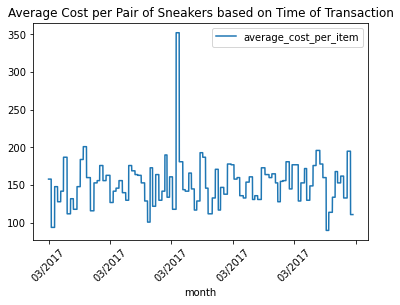

In [35]:
line_average_cost_per_pair()

## While the three line graphs below seem to portray similar information, the first two line plots are based on the cost per order and items per order, both with respect to time. These two show us that there is an anomaly. 

## The third line plot is indicative of average cost of sneakers per order with respect to time.
### Histogram of average cost of each sneaker confirms as well

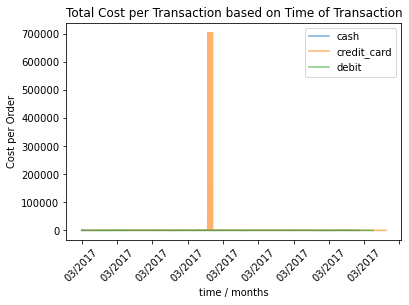

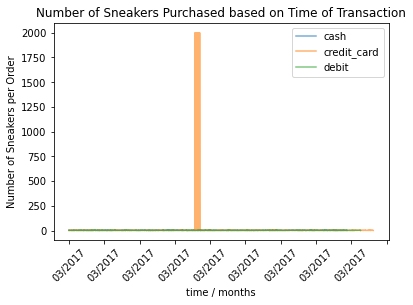

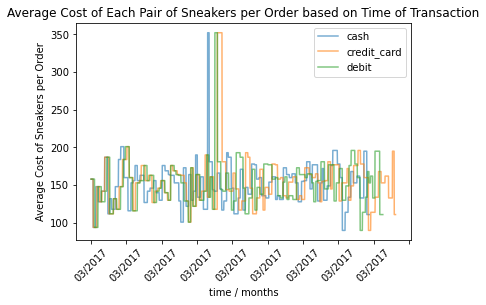

In [36]:
#data['month'] = pd.to_datetime(data['created_at']).dt.strftime('%m/%Y')
time_based = data
time_based.set_index('month',inplace = True)
time_based.groupby('payment_method')['order_amount'].plot(legend = True, x_compat=True, alpha = 0.6, title = 'Total Cost per Transaction based on Time of Transaction')
plt.xticks(rotation = '45')
plt.xlabel('time / months')
plt.ylabel('Cost per Order')
plt.show()
plt.close()
time_based.groupby('payment_method')['total_items'].plot(legend = True, x_compat=True, alpha = 0.6, title = 'Number of Sneakers Purchased based on Time of Transaction')
plt.xticks(rotation = '45')
plt.xlabel('time / months')
plt.ylabel('Number of Sneakers per Order')
plt.show()
plt.close()


#print(time_based)
time_based.groupby('payment_method')['average_cost_per_item'].plot(legend = True, x_compat=True, alpha = 0.6, title = 'Average Cost of Each Pair of Sneakers per Order based on Time of Transaction')
plt.xticks(rotation = '45')
plt.xlabel('time / months')
plt.ylabel('Average Cost of Sneakers per Order')
plt.show()
plt.close()




That anomalous average cost per sneaker, around $350, is interesting. I want to find what that is and where it is from.

### The bar chart shows the higher priced sneakers are likely from one store, more investigation required

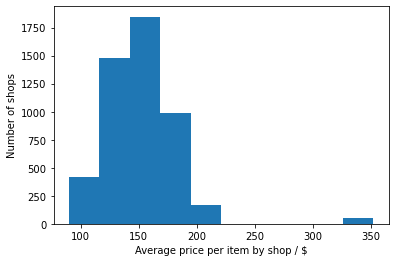

Number of shops that belong to each average price bin that belongs to the above histogram:
 [ 420. 1478. 1847.  990.  168.    0.    0.    0.    0.   51.]


In [37]:
counts_42, edges_42 = hist_average_cost(data)

In [38]:
print(data['average_cost_per_item'].max())

352.0


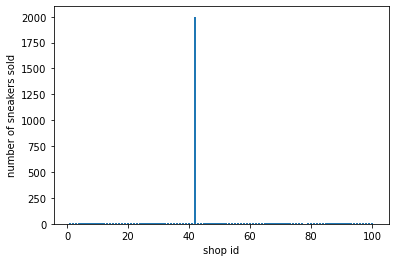

In [39]:
plt.bar(data['shop_id'],data['total_items'])
plt.xlabel('shop id')
plt.ylabel('number of sneakers sold')
plt.show()

***
## Showing dataframe again, but only for the store that has the abnormal high sneaker cost
Another assumption, the store that is selling for a higher cost may be bundling the sneakers with another pair of sneakers or another item. 

In [40]:
max_average_cost_df = (data[data['average_cost_per_item'] == data['average_cost_per_item'].max()])
((data[data['average_cost_per_item'] == data['average_cost_per_item'].max()]).set_index(['user_id','transaction_time']).sort_values(by= ['user_id','transaction_time']))


order_id  shop_id  order_amount  total_items  \
user_id transaction_time                                                 
607     03/02/2017 04:00       521       42        704000         2000   
        03/02/2017 04:00      4647       42        704000         2000   
        03/04/2017 04:00        61       42        704000         2000   
        03/07/2017 04:00        16       42        704000         2000   
        03/07/2017 04:00      2298       42        704000         2000   
        03/11/2017 04:00      1437       42        704000         2000   
        03/12/2017 04:00      2154       42        704000         2000   
        03/15/2017 04:00      1363       42        704000         2000   
        03/17/2017 04:00      1603       42        704000         2000   
        03/19/2017 04:00      1563       42        704000         2000   
        03/22/2017 04:00      4869       42        704000         2000   
        03/24/2017 04:00      1105       42        704000         2000   
        03/24/2017 04:00      3333       42        704000         2000   
        03/25/2017 04:00      4883       42        704000         2000   
        03/28/2017 04:00      2836       42        704000         2000   
        03/28/2017 04:00      2970       42        704000         2000   
        03/28/2017 04:00      4057       42        704000         2000   
720     03/14/2017 10:26      4768       42           704            2   
726     03/24/2017 17:51      3514       42          1056            3   
736     03/01/2017 12:19      4422       42           704            2   
739     03/01/2017 12:42      2019       42           352            1   
        03/07/2017 05:42      1912       42           704            2   
744     03/12/2017 13:09       980       42           352            1   
747     03/27/2017 20:48      2274       42           704            2   
756     03/22/2017 13:10      1521       42           704            2   
770     03/11/2017 18:14       309       42           352            1   
        03/17/2017 08:11      1930       42           352            1   
788     03/16/2017 23:37      4327       42           704            2   
792     03/25/2017 21:31       835       42           352            1   
793     03/24/2017 14:15        41       42           352            1   
797     03/10/2017 06:28      1365       42          1760            5   
808     03/13/2017 23:43       939       42          1056            3   
809     03/11/2017 08:21      4626       42           352            1   
819     03/03/2017 09:09      2988       42          1056            3   
        03/09/2017 14:15       836       42           704            2   
830     03/24/2017 22:26      3652       42           352            1   
839     03/12/2017 02:45      3698       42           352            1   
859     03/24/2017 20:50      4295       42           704            2   
868     03/01/2017 18:33      2492       42           704            2   
        03/23/2017 18:10      2610       42           704            2   
872     03/24/2017 00:57      4746       42           352            1   
886     03/09/2017 20:10      3999       42           352            1   
904     03/04/2017 14:32       410       42           704            2   
907     03/12/2017 23:00      1472       42          1408            4   
926     03/13/2017 02:38      1368       42          1408            4   
934     03/26/2017 09:21      2004       42           704            2   
946     03/24/2017 13:35      1513       42           352            1   
951     03/19/2017 11:49      2054       42           352            1   
962     03/04/2017 00:01      4232       42           352            1   
970     03/05/2017 10:45      2767       42           704            2   
975     03/12/2017 01:28      3904       42           352            1   

                         payment_method       created_at  \
user_id transaction_time                   

## 51 transactions occurred at this higher price, all from store 42
The $352 pair of sneakers only appeared in the month of March (2017)

In [41]:
print('Number of unique customers based on user_id column:', max_average_cost_df['user_id'].nunique())
print('Number of transactions:', max_average_cost_df.value_counts('average_cost_per_item'))

Number of unique customers based on user_id column: 31
Number of transactions: average_cost_per_item
352.0    51
dtype: int64


***
## Cleaning shop 42 out due to anomaly in sneaker pricing

In [42]:
cleaned_data = data[data['average_cost_per_item'] != data['average_cost_per_item'].max()]
cleaned_data

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,average_cost_per_item,transaction_time
month,,,,,,,,,
03/2017,42,1,847,316,2,debit,3/20/2017 14:58,158.0,03/20/2017 14:58
03/2017,348,1,907,158,1,credit_card,3/3/2017 6:59,158.0,03/03/2017 06:59
03/2017,375,1,948,632,4,cash,3/10/2017 13:40,158.0,03/10/2017 13:40
03/2017,389,1,713,316,2,cash,3/12/2017 22:22,158.0,03/12/2017 22:22
03/2017,589,1,725,316,2,credit_card,3/9/2017 6:58,158.0,03/09/2017 06:58
...,...,...,...,...,...,...,...,...,...
03/2017,4233,100,995,222,2,cash,3/26/2017 11:13,111.0,03/26/2017 11:13
03/2017,4425,100,927,333,3,debit,3/13/2017 12:36,111.0,03/13/2017 12:36
03/2017,4429,100,997,111,1,debit,3/22/2017 1:27,111.0,03/22/2017 01:27


### Computing to see if the average and remaining shopify dataset is statistically relevant


In [43]:
list_items = AOV_find(cleaned_data)
stdev =  (cleaned_data['average_cost_per_item'].std())
print("Standard Deviation of AOV:" ,money_format(stdev))
time_based = cleaned_data
min_price = cleaned_data['average_cost_per_item'].min()
max_price = cleaned_data['average_cost_per_item'].max()
print("Minimum Sneaker Pricing:", money_format(min_price))
print("Maximum Sneaker Pricing:", money_format(max_price))

AOV = (np.mean(np.array(list_items))) 





Median cost per item: $153
Average cost per item based on total cost of all items: $150.4
Standard Deviation of AOV: $23.85
Minimum Sneaker Pricing: $90
Maximum Sneaker Pricing: $201


## The minimum and maximum sneaker prices are within 3 standard deviations of the AOV
***
## The histogram has a better distribution of average pricing per sneaker and the line graph shows that prices fluctuate between \\$100-$200 per pair
### purchases using credit/cash/debit visually appear to be irrelevant, but more investigations can probably tell us more information

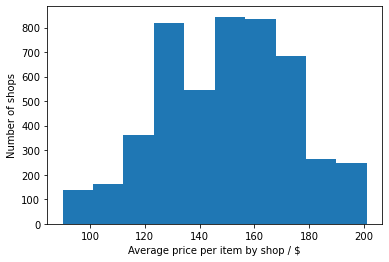

Number of shops that belong to each average price bin that belongs to the above histogram:
 [139. 164. 362. 817. 547. 844. 833. 684. 266. 247.]


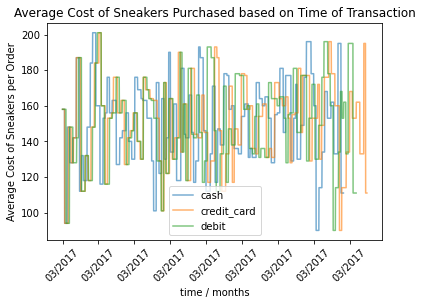

In [44]:
counts_cleaned, edges_cleaned = hist_average_cost(cleaned_data)

time_based.groupby('payment_method')['average_cost_per_item'].plot(legend = True, x_compat=True, alpha = 0.6, title = 'Average Cost of Sneakers Purchased based on Time of Transaction')
plt.xticks(rotation = '45')
plt.xlabel('time / months')
plt.ylabel('Average Cost of Sneakers per Order')
plt.show()
plt.close()

### Average cost of each sneakers of \\$150.40 was found based on the mean of each pair of sneakers purchased, NOT based on each order. 

### Also, this was found after removing all average price per item that was equal to \\$25725. This was either a currency error or an input error. \\$257.25 seems more likely, but I removed this data because I didn't want to alter the real data. 

### Next, I removed the order data associated with shop_id 42. In the month of March (2017), it appeared that they were upselling or bundling sneakers with another item, causing for the price to go above the average cost of sneakers that I finally was able toconclude. The latter is more likely in the sneaker community, so i omitted shop_id 42 from the final calculation.

# Getting to a more accurate AOV

In [48]:
cleaned_data.describe()


,order_id,shop_id,user_id,order_amount,total_items,average_cost_per_item
count,4903.000000,4903.000000,4903.000000,4903.000000,4903.000000,4903.000000
mean,2499.584540,49.900877,849.858862,300.155823,1.995717,150.400163
std,1444.221163,29.154367,86.887947,155.941112,0.982602,23.851202
min,1.000000,1.000000,700.000000,90.000000,1.000000,90.000000
25%,1246.500000,24.000000,776.000000,163.000000,1.000000,132.000000
50%,2499.000000,50.000000,850.000000,284.000000,2.000000,153.000000
75%,3750.500000,74.000000,925.000000,386.500000,3.000000,166.000000
max,5000.000000,100.000000,999.000000,1086.000000,8.000000,201.000000


In [51]:
print(money_format(cleaned_data['order_amount'].median()))

$284


# The mean value of *order_amount* shows that the AOV is approximately \\$300.16, while the median value of this field is \\$284
# After doing some cleaning and viewing the skewedness of the *order_amount* column via the histogram below, the median value is more appropriate to use for the AOV

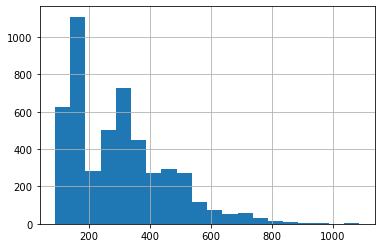

In [55]:
cleaned_data['order_amount'].hist(bins = 20)
plt.show()